BOX 1: reading packages

In [49]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro, chisquare


BOX 2 reading the csv + checking each column for null values

In [2]:
df = pd.read_csv('udemy_database.csv')
has_nulls = df.isnull().any()
print(has_nulls)

course_id              False
course_title           False
url                    False
is_paid                False
price                  False
num_subscribers        False
num_reviews            False
num_lectures           False
level                  False
content_duration       False
published_timestamp    False
subject                False
dtype: bool


BOX 3 checking for duplicates - there where 4 duplicates

In [3]:
course_counts = df['course_id'].value_counts()

duplicates = course_counts[course_counts > 1]
print(duplicates)

df.drop_duplicates(subset='course_id', inplace=True)


course_id
1035638    2
185526     2
1084454    2
837322     2
1157298    2
28295      2
Name: count, dtype: int64


BOX 3: detecting outliers
method: https://bpb-us-w2.wpmucdn.com/sites.umassd.edu/dist/f/1316/files/2023/01/Statistics-for-Nursing-and-Allied-Health-PDFDrive-.pdf#page=34
Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69

In [4]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


BOX 4: the outliers intersection based on numeric variables

In [5]:
common_outliers_pairwise = {}

for col1, col2 in combinations(outliers_dict.keys(), 2):
    outliers_col1 = set(outliers_dict[col1]['course_id']) if isinstance(outliers_dict[col1], pd.DataFrame) else set(outliers_dict[col1])
    outliers_col2 = set(outliers_dict[col2]['course_id']) if isinstance(outliers_dict[col2], pd.DataFrame) else set(outliers_dict[col2])

    common_outliers = outliers_col1.intersection(outliers_col2)

    common_outliers_pairwise[f"{col1} & {col2}"] = common_outliers

for columns, common_outliers in common_outliers_pairwise.items():
    print(f"Common outliers for {columns}:", len(common_outliers))
    for course_id in common_outliers:
        print(f"  - Course ID {course_id}")
    print()



Common outliers for course_id & price: 0

Common outliers for course_id & num_subscribers: 0

Common outliers for course_id & num_reviews: 0

Common outliers for course_id & num_lectures: 0

Common outliers for course_id & content_duration: 0

Common outliers for price & num_subscribers: 0

Common outliers for price & num_reviews: 0

Common outliers for price & num_lectures: 0

Common outliers for price & content_duration: 0

Common outliers for num_subscribers & num_reviews: 20
  - Course ID 764164
  - Course ID 364426
  - Course ID 130064
  - Course ID 519442
  - Course ID 437398
  - Course ID 719002
  - Course ID 405926
  - Course ID 625204
  - Course ID 756150
  - Course ID 446134
  - Course ID 473160
  - Course ID 48841
  - Course ID 289230
  - Course ID 41295
  - Course ID 238934
  - Course ID 314462
  - Course ID 461160
  - Course ID 173548
  - Course ID 705264
  - Course ID 707962

Common outliers for num_subscribers & num_lectures: 10
  - Course ID 764164
  - Course ID 11174
 

BOX 5: plotting the data to better see the outliers

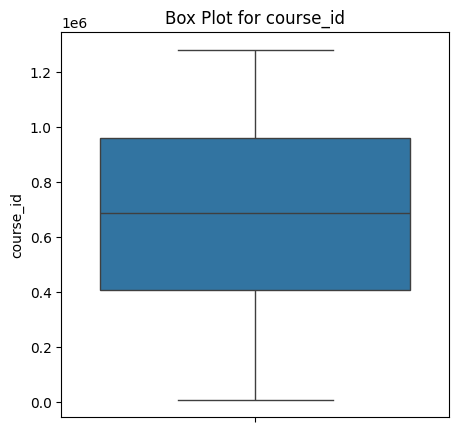

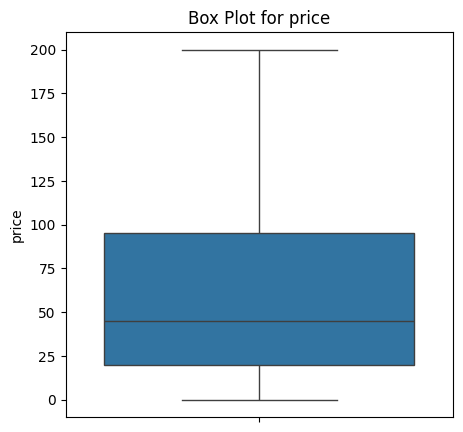

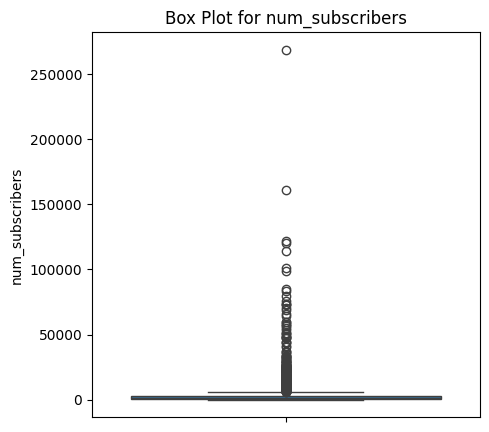

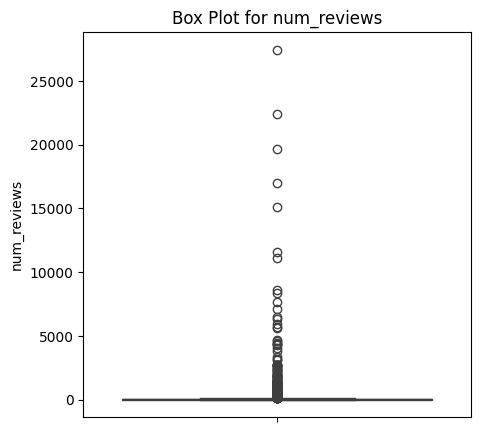

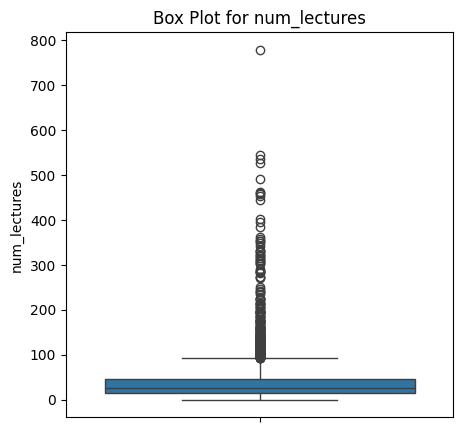

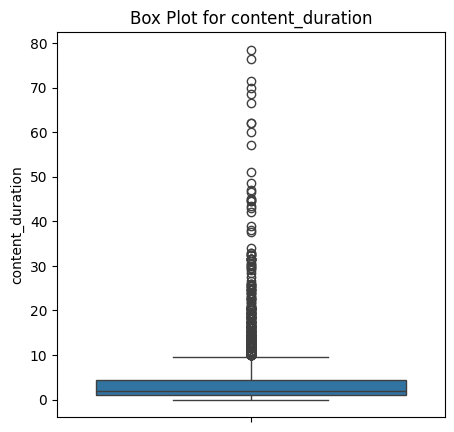

In [6]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=df[column])  
    plt.title(f'Box Plot for {column}')
    plt.ylabel(column)
    plt.show()

BOX 6 Perform a Chi-Square Test for Goodness of Fit on observed categorical counts.

In [7]:
def chi_square_test(observed_values, alpha=0.05):

    expected_counts = [sum(observed_values) / len(observed_values)] * len(observed_values)

    chi2_stat, p_value = chisquare(f_obs=observed_values, f_exp=expected_counts)

    result = "reject the null hypothesis" if p_value < alpha else "fail to reject the null hypothesis"
    
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")

    # print(f"Observed Values: {observed_values}")
    # print(f"Expected Values: {expected_counts}")
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")
    
    return {
        f"Chi-Square Statistic: {chi2_stat}",
        f"P-Value: {p_value}",
        f"Result: {result}"
    }

In [8]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


BOX 7 BARCHART: count all the courses taking into account the subject

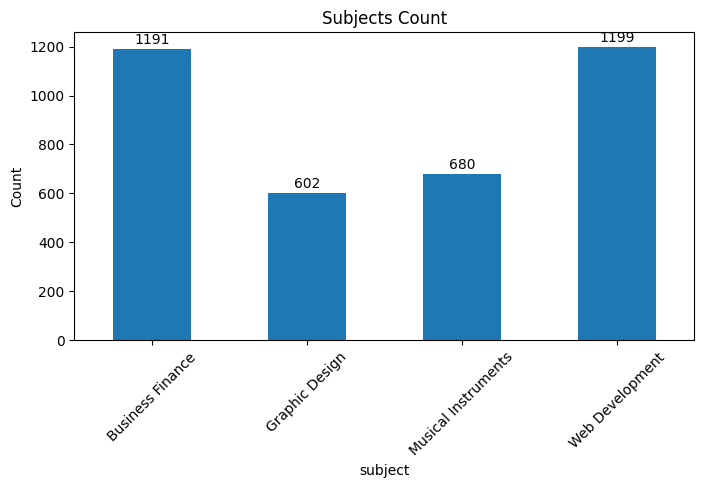

In [9]:
category = df.groupby('subject')['subject'].count()

plt.figure(figsize=(8, 4))
for i, v in enumerate(category.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
category.plot(kind='bar')
plt.title('Subjects Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

BOX 9 BARCHART: avg duration for each course per category, regardeless of the platform

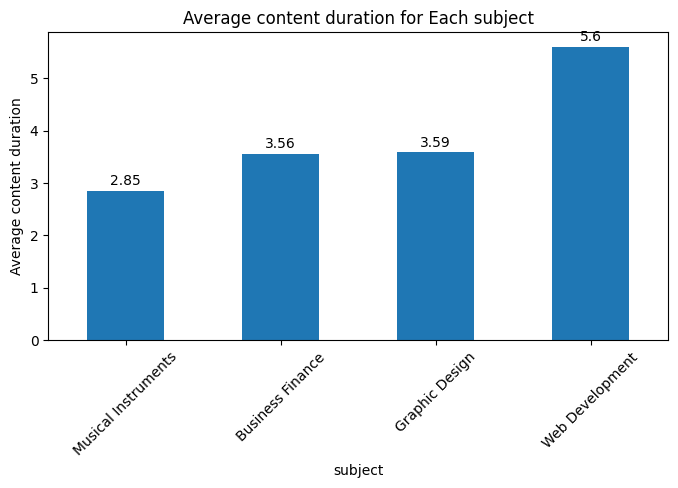

In [10]:
avg_duration_cat = df.groupby('subject')['content_duration'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_duration_cat.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_duration_cat.plot(kind='bar')
plt.title('Average content duration for Each subject')
plt.xlabel('subject')
plt.ylabel('Average content duration')
plt.xticks(rotation=45)
plt.show()

BOX 13 BARCHART: total number of subscribers enrolled for each subject

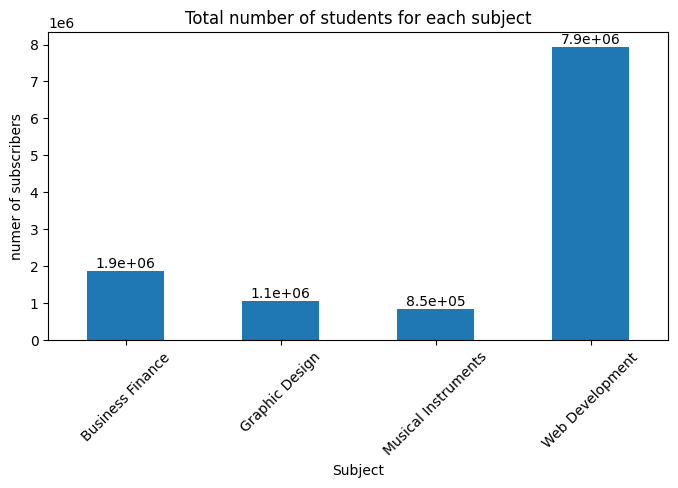

In [26]:
total_enrolled_stud = df.groupby('subject')['num_subscribers'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_enrolled_stud.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_enrolled_stud.plot(kind='bar')
plt.title('Total number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

BOX 13.1 BARCHART: total number of reviews for each subject

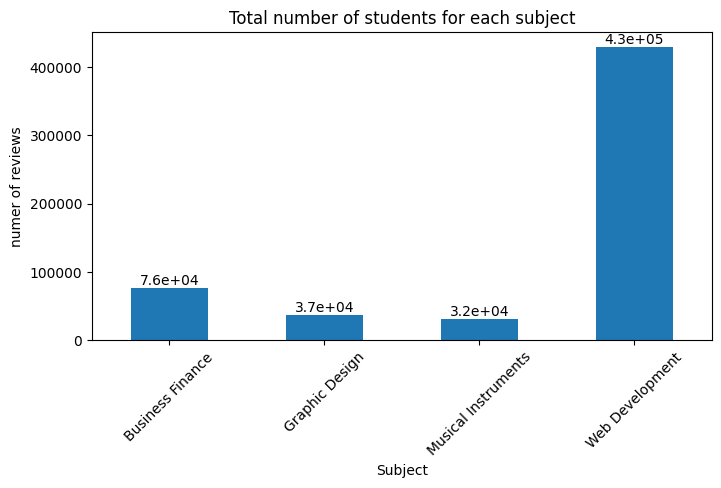

In [ ]:
total_enrolled_stud = df.groupby('subject')['num_reviews'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_enrolled_stud.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_enrolled_stud.plot(kind='bar')
plt.title('Total number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

BOX 13.2 BARCHART: total number of professors for each subject

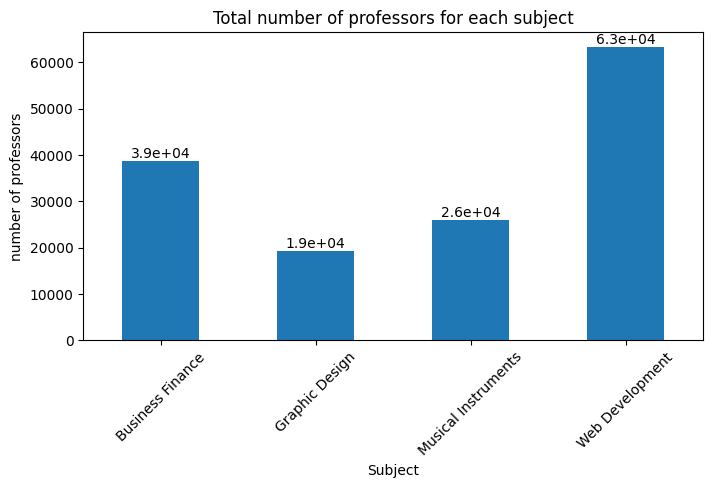

In [29]:
total_enrolled_stud = df.groupby('subject')['num_lectures'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_enrolled_stud.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_enrolled_stud.plot(kind='bar')
plt.title('Total number of professors for each subject')
plt.xlabel('Subject')
plt.ylabel('number of professors')
plt.xticks(rotation=45)
plt.show()

BOX 15 BARCHART: avg prices for each subject

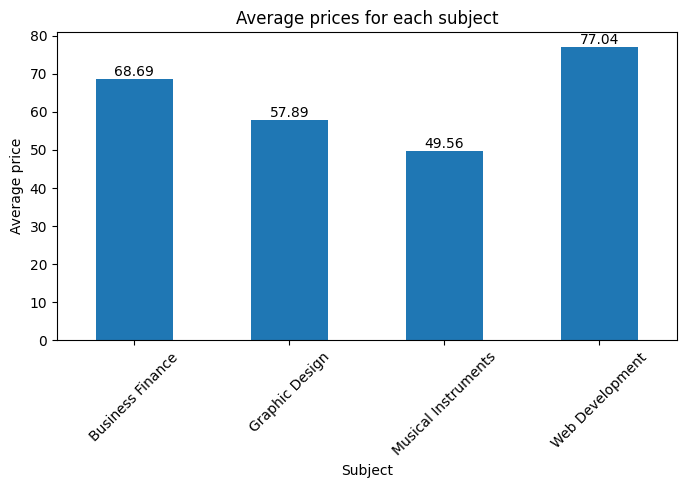

In [30]:
avg_price = df.groupby('subject')['price'].mean()

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_price.values):
    plt.text(i, round(v,2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_price.plot(kind='bar')
plt.title('Average prices for each subject')
plt.xlabel('Subject')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.show()

In [ ]:
avg_price = df.groupby('Platform')['Price ($)'].mean()

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_price.values):
    plt.text(i, round(v,2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_price.plot(kind='bar')
plt.title('Average prices for each e-learning platform')
plt.xlabel('Platform')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.show()

checking normal distibutions


Analyzing course_id:


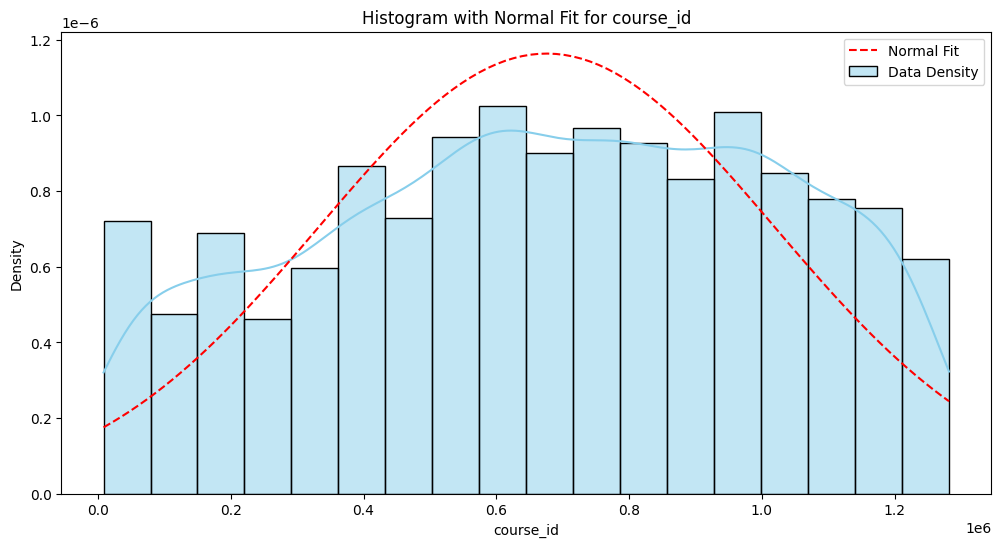

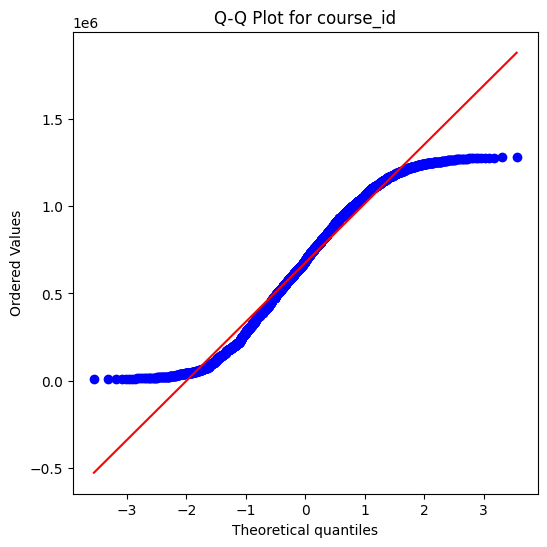

Shapiro-Wilk Test for course_id: Statistic=0.9679, p-value=0.0000
course_id does NOT follow a normal distribution.

Analyzing price:


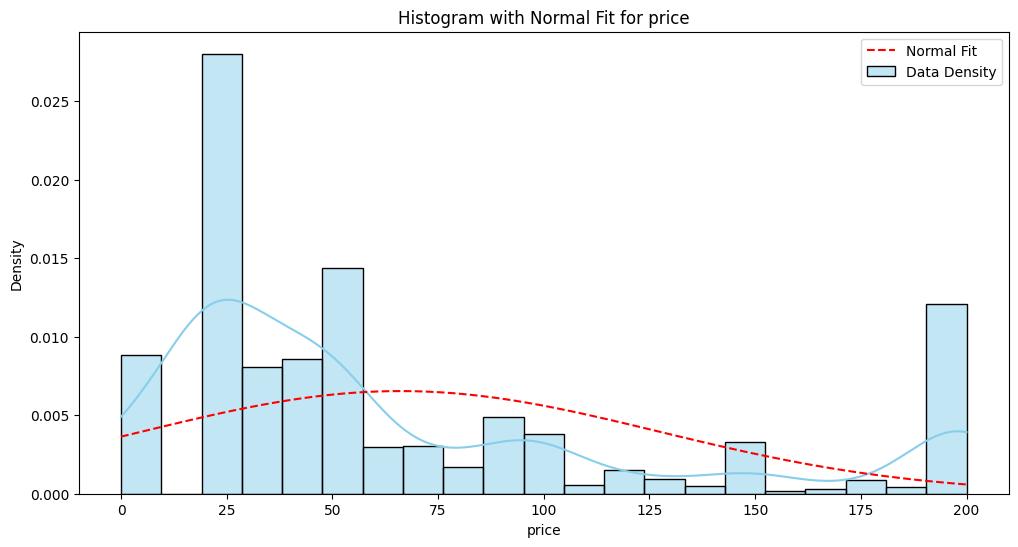

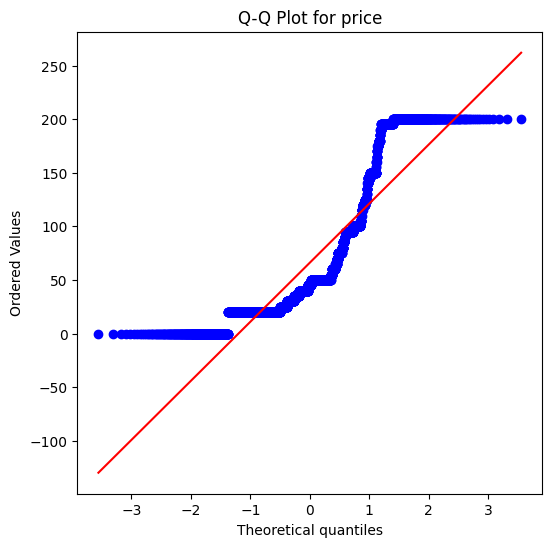

Shapiro-Wilk Test for price: Statistic=0.8126, p-value=0.0000
price does NOT follow a normal distribution.

Analyzing num_subscribers:


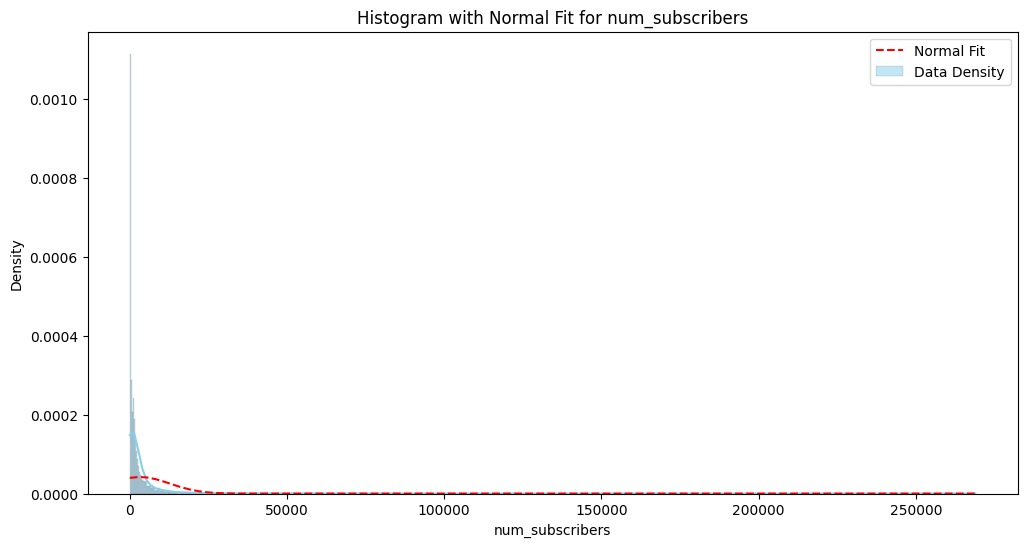

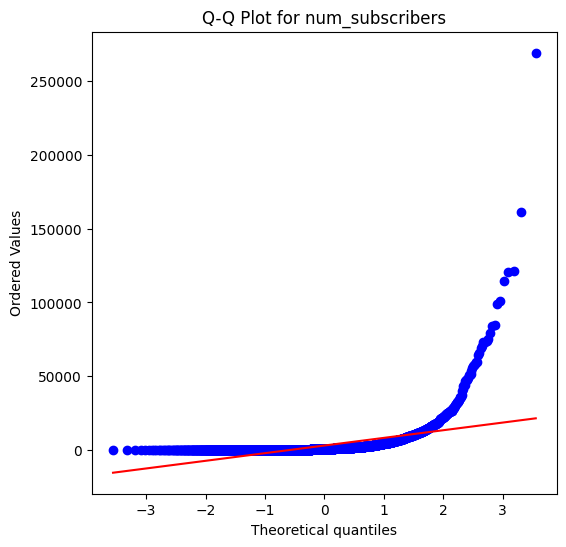

Shapiro-Wilk Test for num_subscribers: Statistic=0.2992, p-value=0.0000
num_subscribers does NOT follow a normal distribution.

Analyzing num_reviews:


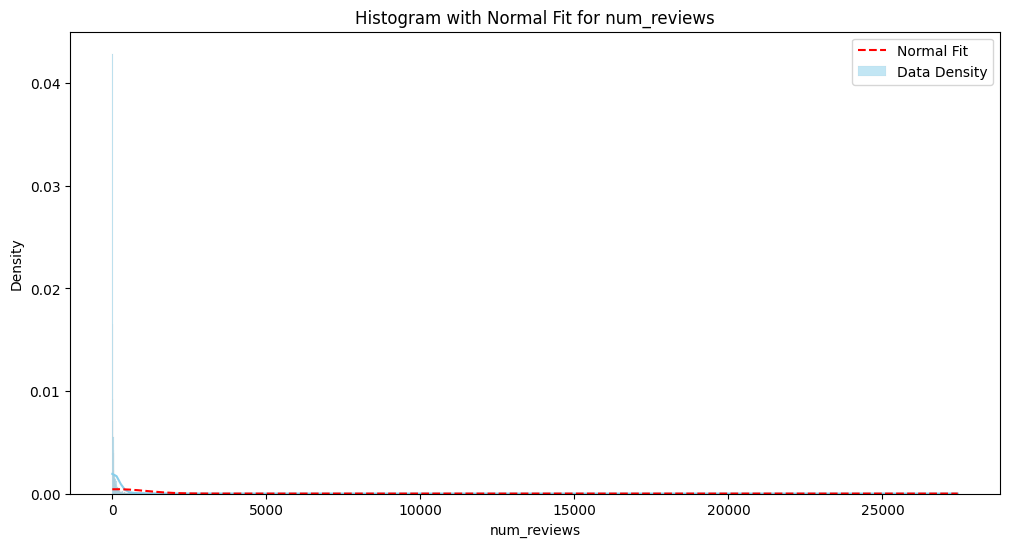

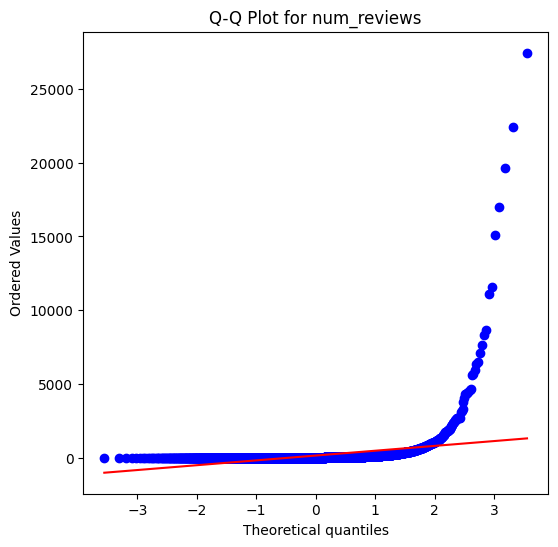

Shapiro-Wilk Test for num_reviews: Statistic=0.1234, p-value=0.0000
num_reviews does NOT follow a normal distribution.

Analyzing num_lectures:


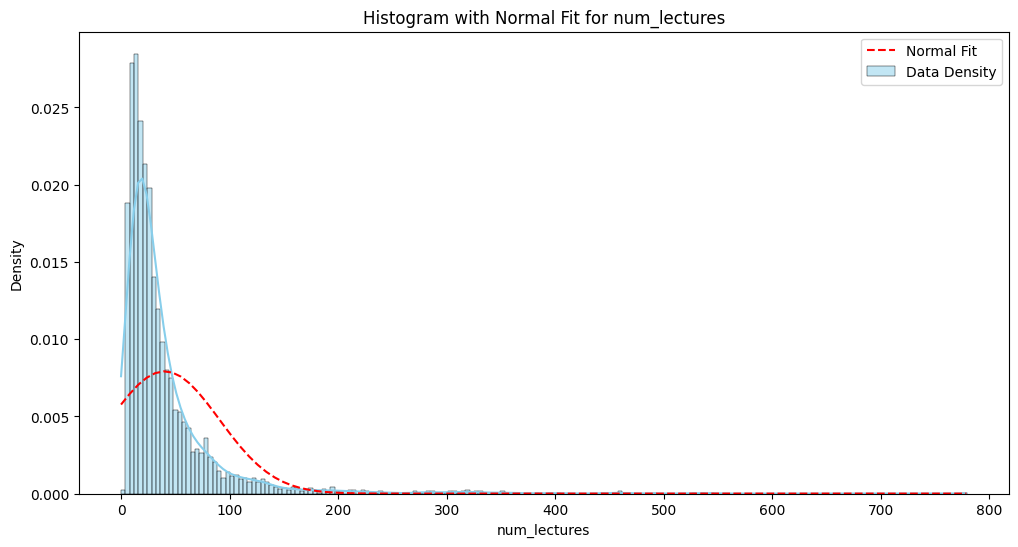

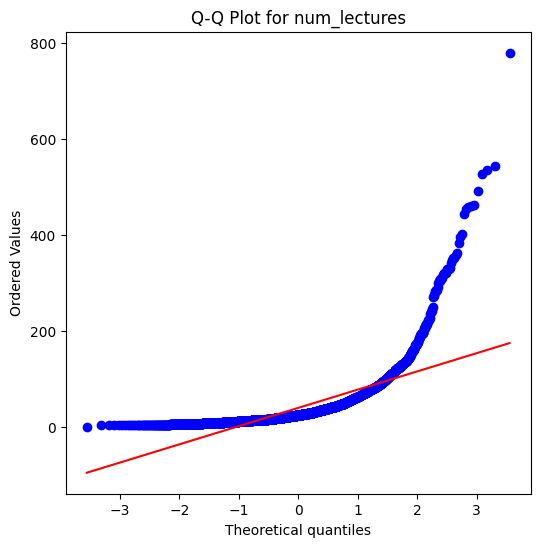

Shapiro-Wilk Test for num_lectures: Statistic=0.5661, p-value=0.0000
num_lectures does NOT follow a normal distribution.

Analyzing content_duration:


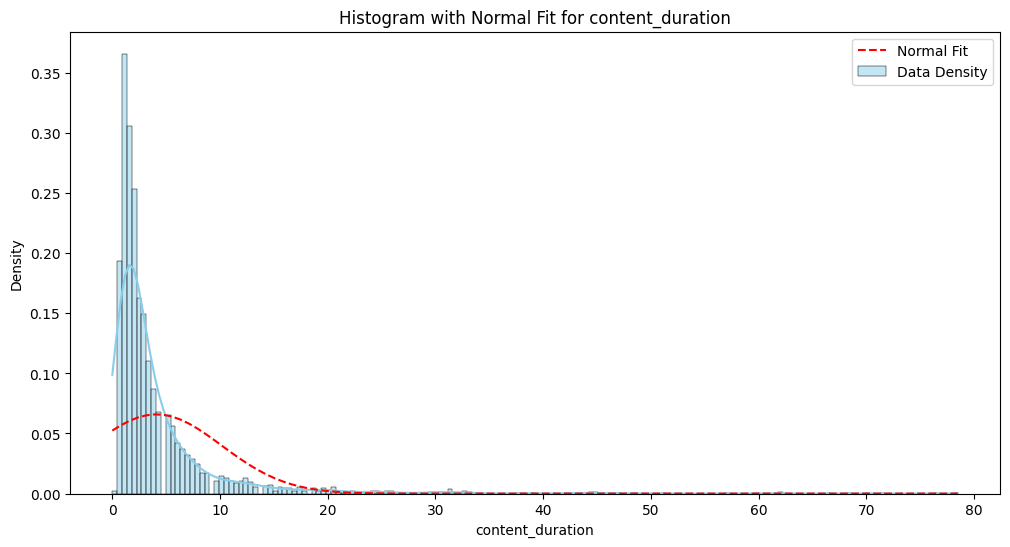

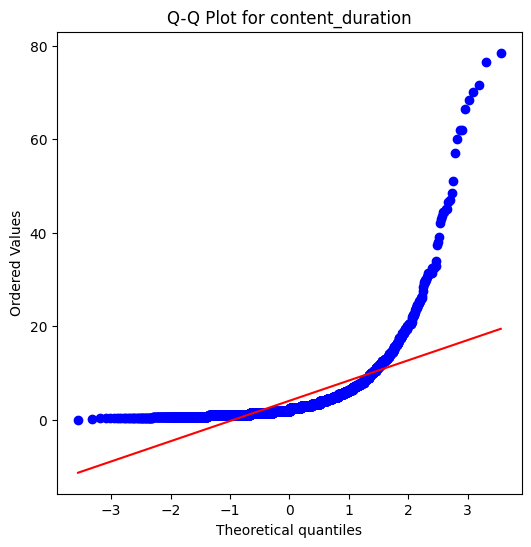

Shapiro-Wilk Test for content_duration: Statistic=0.5104, p-value=0.0000
content_duration does NOT follow a normal distribution.


In [24]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    print(f"\nAnalyzing {column}:")

    plt.figure(figsize=(12, 6))
    sns.histplot(df[column].dropna(), kde=True, stat="density", color="skyblue", label="Data Density")
 
    mean, std = norm.fit(df[column].dropna()) 
    x = np.linspace(df[column].min(), df[column].max(), 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'r--', label="Normal Fit")
    plt.title(f"Histogram with Normal Fit for {column}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    from scipy.stats import probplot
    probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {column}")
    plt.show()

    stat, p_value = shapiro(df[column].dropna())
    print(f"Shapiro-Wilk Test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}")
    
    if p_value < 0.05:
        print(f"{column} does NOT follow a normal distribution.")
    else:
        print(f"{column} follows a normal distribution.")

THE PRICE EVOLUTION

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Evaluate the model on the test set
r_squared = model.score(X_test, y_test)
print(f"R-squared: {r_squared}")



Coefficients: [-2.62596928e-04  3.85041797e-03  2.86053281e-01  1.08257730e+00]
Intercept: 50.273652156488964
R-squared: 0.10227165031676777
